In [1]:
#setup plotting and special functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from numpy import exp as exp

## Define the conditional PDF using a gamma approximation

To find the standard deviation of the random variable sum, $X = \sum_{i=1}^{T_w} f(q_i)$, the co-variance function of $f$ is summed over all pairs of days for the season: $\sigma_X = \sqrt{\sum_i \sum_j \text{Cov} \left[f(Q_i), f(Q_j)\right]}$

In order obtain an expression for the co-variance function, $\text{Cov}\left[f(Q_i), f(Q_j)\right]$, we require the PDF of $Q_i$ conditional on $Q_j$, or $p_{Q_i | Q_j}(q_i, q_j)$. This expression can be found as Equation 4 in *Viola et al* [2008, doi:10.1029/2007WR006371]. The hypergeometric function found in this equation is numerically unstable for large arguments. We therefore approximate the continous portion of $p_{Q_i | Q_j}(q_i, q_j)$ using an appropriately normalized and shifted gamma distribution. 

In [2]:
gam = 0.25 # mean inverse discharge increment, in cm/day
lam = 0.15  # poisson occurence frequency of recharge events, in days-1
k = 0.3  # recession constant, in days-1
tw = 100 # length in days over which sum is taken
meanQ = lam/(k*gam)
varQ = lam/(k*gam**2)

# function for the mean of the transient PDF
def get_tm(gam, lam, k, qj, tau=1):
    ektau = exp(-k*tau)
    return (lam - ektau*lam + ektau*gam*k*qj)/(gam*k)

# function for the variance of the transient PDF
def get_tv(gam, lam, k, qj, tau=1):
    ektau = exp(-k*tau)
    qi2 = ((-1 + ektau)**2*lam**2 + ektau**2*gam**2*k**2*qj**2 - (-1 + ektau)*k*lam*(1 + ektau + 2*ektau*gam*qj))/(gam**2*k**2)
    mu = get_tm(gam, lam, k, qj, tau)
    return qi2 - mu**2

# get the shape parameter of the gamma distribution used to approximate the transient PDF
def get_a(gam, lam, k, qj, tau=1):
    ektau = exp(-k*tau)
    elamtau = exp(-lam*tau)
    tm = get_tm(gam, lam, k, qj, tau)
    tv = get_tv(gam, lam, k, qj, tau)
    return -((-(ektau*qj) + tm)**2/(elamtau*(-(ektau*qj) + tm)**2 + (-1 + elamtau)*tv))

# get the scale parameter of the gamma distribution used to approximate the transient PDF
def get_b(gam, lam, k, qj, tau=1):
    ektau = exp(-k*tau)
    elamtau = exp(-lam*tau)
    tm = get_tm(gam, lam, k, qj, tau)
    tv = get_tv(gam, lam, k, qj, tau)
    return (elamtau*(-(ektau*qj) + tm))/(-1 + elamtau) - tv/(ektau*qj - tm)

# function to return the transient PDF of qi given qj, with tau = abs(i-j)
def qConditional(qj,qi,lam,k,gam,tau=1):
    if qi < qj*exp(-k*tau): 
        p = 0 
    else: 
        a = get_a(gam, lam, k, qj, tau)
        b = get_b(gam, lam, k, qj, tau)
        ektau = exp(-k*tau)
        elamtau = exp(-lam*tau)
        p = (1-elamtau)*b**(-a)*exp(-(qi-ektau*qj)/b)*(qi-ektau*qj)**(a-1)/special.gamma(a)
    return p

# steady state PDF of daily Q 
ss = lambda q: 1/(special.gamma(lam/k)*1/gam**(lam/k))*q**(lam/k-1)*np.exp(-q*gam)

## User defined function

The user defines a (required) power law function of the daily flow variable $(f)$ for which the co-variance will be computed. 

In [3]:
# parameters of power law function
args = [1.0, 1.5]
def f(q,args):
    return args[0]*q**args[1]

# assuming the function f is power law,
# the mean and variance of the daily value of 
# f are known analytically
beta = args[0]; delta = args[1]
mean_f = beta*gam**(lam/k - (delta*k+lam)/k)*special.gamma(delta+lam/k)/(special.gamma(lam/k))
var_f = (beta**2*(-special.gamma(delta + lam/k)**2 + special.gamma(lam/k)*special.gamma(2*delta + lam/k)))/(gam**(2*delta)*special.gamma(lam/k)**2)

## Integrating to get the variance of the sum

In [6]:
# for lag zero, the co-variance is just the variance of the daily variable
cov_viola = [var_f]
qvar = np.linspace(meanQ/1000.0, meanQ + 6*np.sqrt(varQ), 300)
dq = qvar[1]-qvar[0]
TAU = range(1,tw)

# for all potential lags, compute covariance
for tau in TAU:
    PQQ = np.zeros((len(qvar),len(qvar)))
    PQ = np.zeros((len(qvar),len(qvar)))
    central = np.zeros((len(qvar),len(qvar)))
    
    # approximation to speed up computation; 
    # if the remaining lags will contribute negligibly 
    # to sigma_X, fill the remaining elements of the co-variance function
    # with zero. 
    if (np.max([TAU[-1]-tau,1]))*cov_viola[-1] < var_f/100.0:
        cov_viola[-1] = 0
        cov_viola.append(0)
    else:
        for i,qOld in enumerate(qvar):   
            for j,qNew in enumerate(qvar):
                PQQ[i,j] = qConditional(qOld,qNew,lam,k,gam,tau)
                PQ[i,j] = ss(qOld)
                central[i,j] = ( f(qOld,args) - mean_f )*( f(qNew, args) - mean_f)
                
            # we must place an atom of probability capturing the fact that no rain is influencing the transition between days
            # since our grid is linearly spaced, we will not have all the appropriate states -- just find the closest
            J = np.argmin(np.abs(qvar-qOld*np.exp(-k*tau)))
            PQQ[i,J] = np.exp(-lam*tau)/(dq) # divide by dq in order to model Dirac, since this is a 1-D PDF (with qOld fixed) 
        cov_viola.append(np.sum(central*PQQ*PQ*dq**2))
    
    
#get variance of season flow sum, \sum \sum cov(f_i, f_j)
mean_fsum = tw*mean_f
variance_fsum = 0
for i in range(tw):
    for j in range(tw):
        tau = np.abs(i-j)
        variance_fsum += cov_viola[tau]

sd_fsum = np.sqrt(variance_fsum)

# Plot the co-variance function

The standard deviation of the sum is 208.400052921


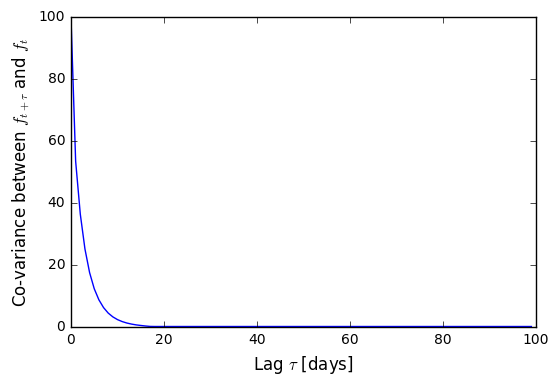

In [10]:
 plt.plot(cov_viola)
plt.xlabel(r'Lag $\tau$ [days]', fontsize=12)
plt.ylabel(r'Co-variance between $f_{t+\tau}$ and $f_t$', fontsize=12)
titlestr = 'The standard deviation of the sum is ' + str(sd_fsum)
print(titlestr)